# load necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

The paths bellow are currently specific to the machine. Also remember to update the hardcoded path in tabula-sapiens/utils/annotation_utils.py

In [ ]:
import sys
import os 

sys.path.append('/home/angela/src/scVI_TSP/')
sys.path.append('/home/angela/sapiens/tabula-sapiens/')

from scvi.dataset import AnnDatasetFromAnnData
from utils.annotations_utils import *

retrain=False

In [2]:
import scanpy as sc

import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

/home/angela/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [3]:
def scVIdata_preprocess(combined, batch_col = 'Tissue Tech', label_col = 'scANVI Prediction By Organ'):
    
#     combined.obs[batch_col].fillna('pilot2', inplace=True)
    combined.obs[label_col].fillna('unassigned', inplace=True)
    tissue_tech_list = list(np.unique(combined.obs[batch_col]))
    batch_id = [tissue_tech_list.index(x) for x in combined.obs[batch_col]]
    combined.obs['batch'] = batch_id
    train_data = AnnDatasetFromAnnData(combined, batch_label='batch')
    labels = combined.obs[label_col]
    train_data.cell_types, train_data.labels = np.unique(labels, return_inverse=True)
    train_data.labels = train_data.labels.reshape(len(train_data.labels), 1)
    train_data.n_labels = len(train_data.cell_types)
    return train_data

# set and create directories for saving results

In [4]:
data_path = '/mnt/ibm_lg/angela/sapiens/'
model_path = '/mnt/ibm_lg/angela/sapiens/scVI_models/TSP2/'
res_path = '/mnt/ibm_lg/angela/sapiens/'

if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(model_path+'scanvi/'):
    os.mkdir(model_path+'scanvi/')
if not os.path.exists(res_path):
    os.mkdir(res_path)

# read annotated pilot2 object

In [5]:
pilot2= sc.read_h5ad(res_path + 'Pilot2.cellontology.h5ad')

In [6]:
pilot2.shape

(272445, 58870)

In [7]:
organs = ['BM', 'Bladder', 'Blood', 'LI', 'Lung','LymphNode', 'Muscle', 'SI', 'Spleen', 'Thymus', 'Trachea','Vasculature']
organ_filter = [x in organs for x in pilot2.obs['tissue']]

In [8]:
pilot2 = pilot2[organ_filter]

In [9]:
pilot2.shape

(208076, 58870)

In [10]:
a,b = np.unique(pilot2.obs['cell_ontology_class'], return_counts=True)
pd.DataFrame([a,b])

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,B cell,Bronchial Vessel,"CD34-positive, CD38-negative multipotent proge...",CD3E CXCR4 cells,CD4-positive helper T cell,"CD4-positive, CD25-positive, alpha-beta regula...","CD4-positive, alpha-beta T cell","CD4-positive, alpha-beta cytotoxic T cell","CD4-positive, alpha-beta memory T cell","CD8-positive, alpha-beta T cell",...,secretory cell,serous cell of epithelium of bronchus,smooth muscle cell,stromal cell,type I pneumocyte,type II pneumocyte,type II pneumocyte signaling,unassigned,vascular associated smooth muscle cell,vein endothelial cell
1,1185,178,316,27,527,7,81,29,112,459,...,809,13,826,80,338,2877,435,154169,214,250


# running label propagation in BM

In [11]:
organ = 'BM'
pilot2_organ = pilot2[pilot2.obs['tissue']==organ].copy()

In [12]:
train_data = scVIdata_preprocess(pilot2_organ, 'Tissue Tech', 'cell_ontology_class')

[2020-06-18 17:10:54,750] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 17:10:54,753] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 17:10:55,089] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 17:10:55,192] INFO - scvi.dataset.dataset | Downsampled from 32939 to 32939 cells


In [ ]:
posterior = get_scvi_posterior(train_data, 
                           model_path+'TSP2.%s.scVI.pkl'%organ, 
                           retrain=retrain)


In [ ]:
full, pred_celltype = scanvi_pred(train_data, 
                                  model_path+'TSP2.%s.scVI.pkl'%organ,
                                  model_path+'TSP2.%s.scANVI.pkl'%organ,
                                  nlabels=30, retrain=retrain)

pred_celltype = np.asarray([train_data.cell_types[x] for x in pred_celltype])

In [ ]:
[x for x in train_data.cell_types if x not in np.unique(pred_celltype)]

In [ ]:
a,b = np.unique(pred_celltype, return_counts=True)
pd.DataFrame([a,b,b/np.sum(b)]).T

In [ ]:
pilot2_organ.obs['propagated_cell_ontology_class'] = pred_celltype

In [ ]:
# pilot2_organ.write_h5ad('Pilot2.cellontology.%s.h5ad'%organ)

In [ ]:
sc.pp.neighbors(pilot2_organ, n_neighbors=20, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(pilot2_organ)

In [ ]:
sc.pl.umap(pilot2_organ, color=['cell_ontology_class','propagated_cell_ontology_class'])

# running label propagation across all tissues

In [ ]:
pwd

Muscle
[2020-06-18 17:18:16,911] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 17:18:16,914] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 17:18:17,503] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 17:18:17,675] INFO - scvi.dataset.dataset | Downsampled from 26274 to 26274 cells


... storing 'propagated_cell_ontology_class' as categorical


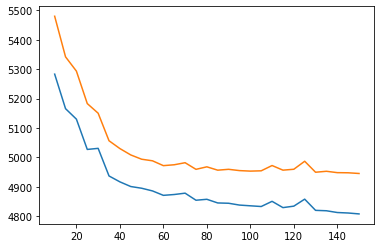

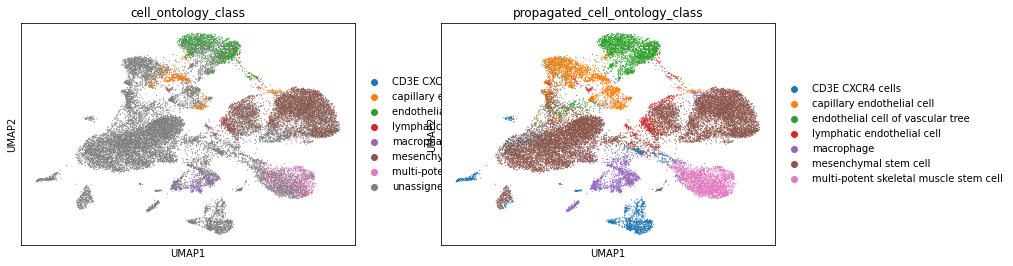

SI
[2020-06-18 17:44:19,613] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 17:44:19,615] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 17:44:19,844] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 17:44:19,903] INFO - scvi.dataset.dataset | Downsampled from 32939 to 32939 cells


... storing 'propagated_cell_ontology_class' as categorical


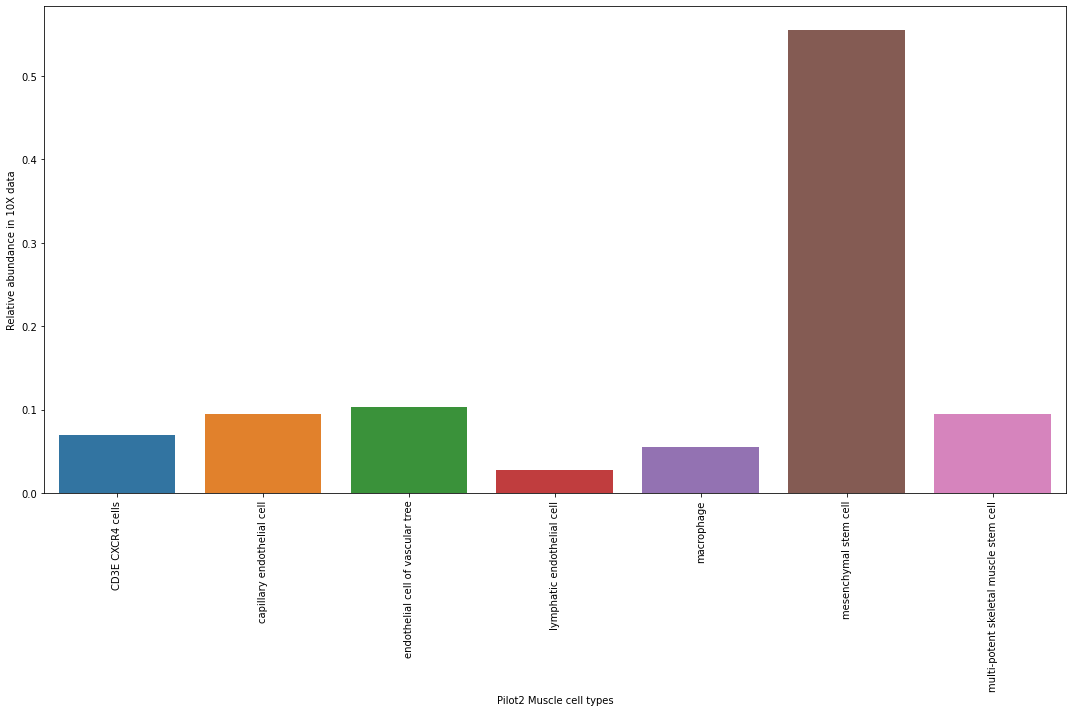

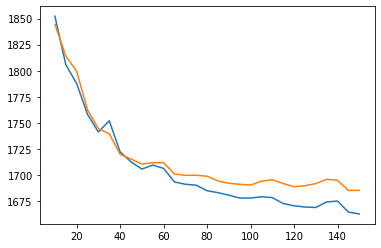

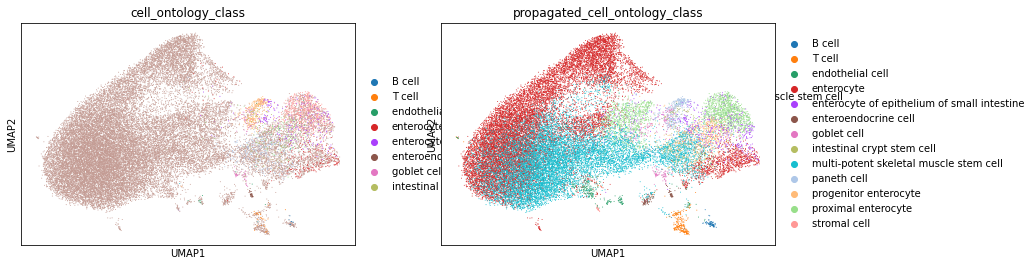

Vasculature
[2020-06-18 18:15:50,015] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 18:15:50,017] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 18:15:50,394] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 18:15:50,478] INFO - scvi.dataset.dataset | Downsampled from 10448 to 10448 cells


... storing 'propagated_cell_ontology_class' as categorical


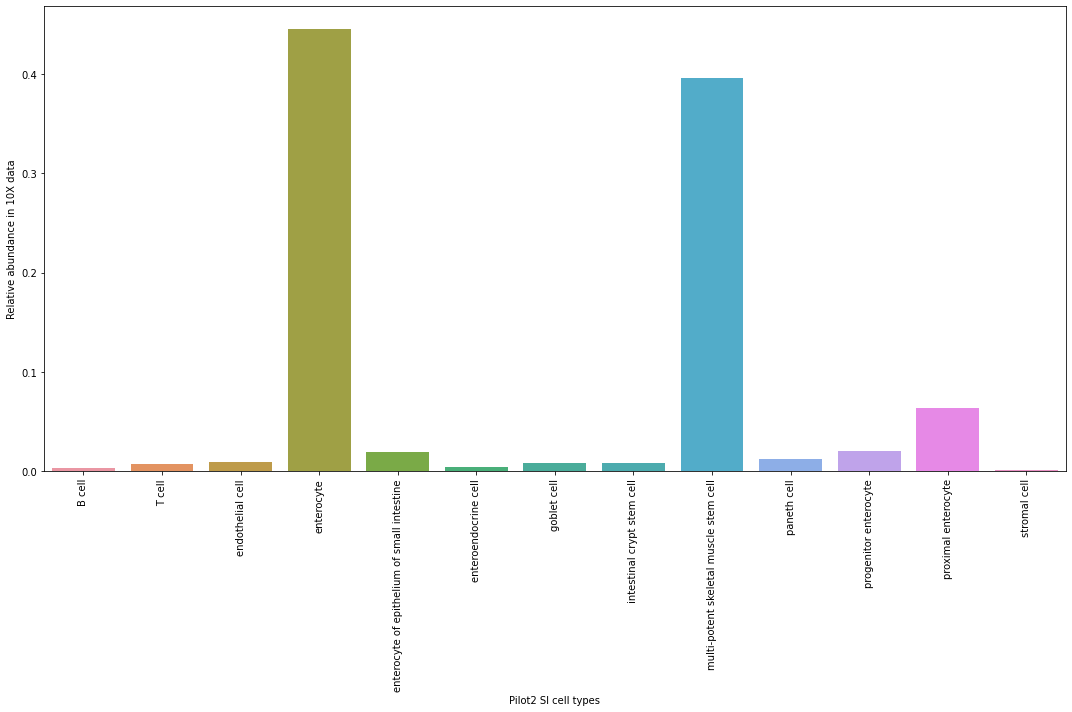

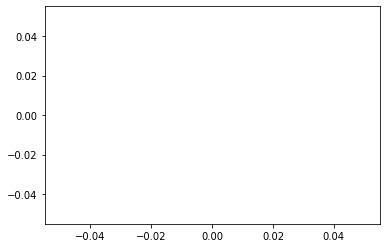

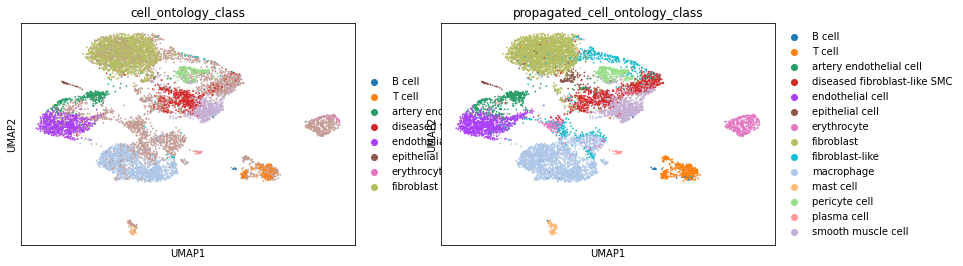

Spleen
[2020-06-18 18:16:26,583] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 18:16:26,586] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 18:16:26,821] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 18:16:26,873] INFO - scvi.dataset.dataset | Downsampled from 9109 to 9109 cells


... storing 'propagated_cell_ontology_class' as categorical


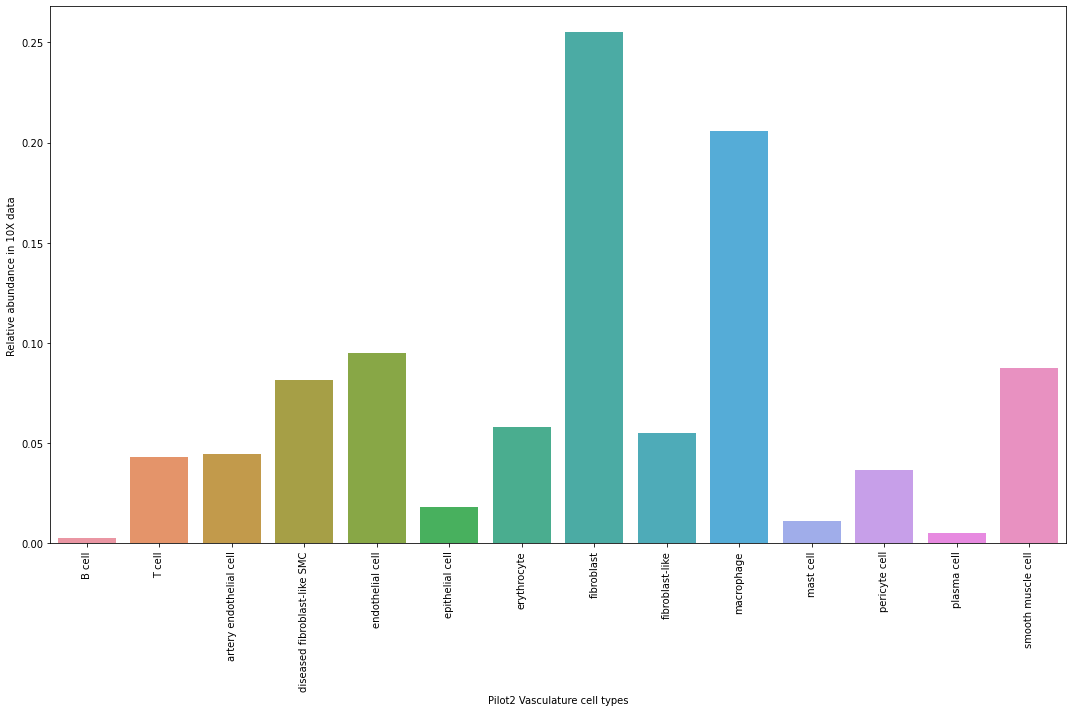

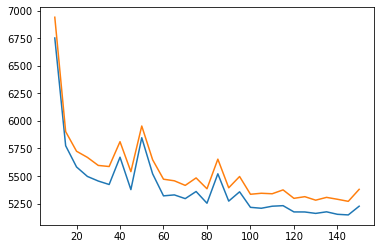

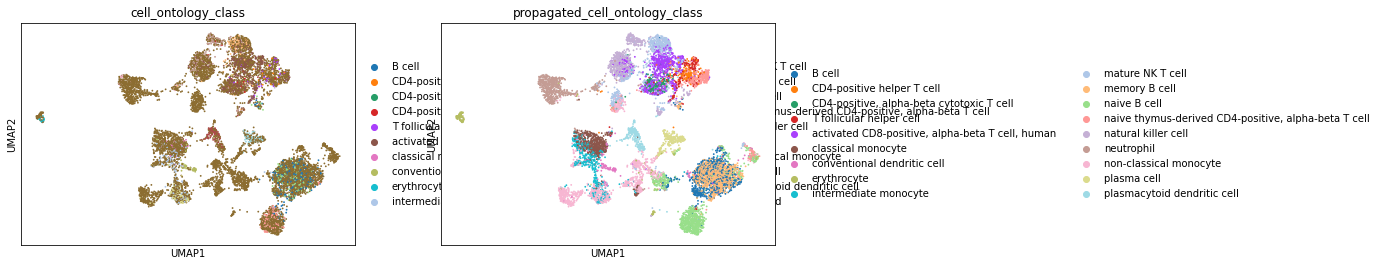

LymphNode
[2020-06-18 18:28:38,410] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 18:28:38,412] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 18:28:38,669] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 18:28:38,725] INFO - scvi.dataset.dataset | Downsampled from 10757 to 10757 cells


... storing 'propagated_cell_ontology_class' as categorical


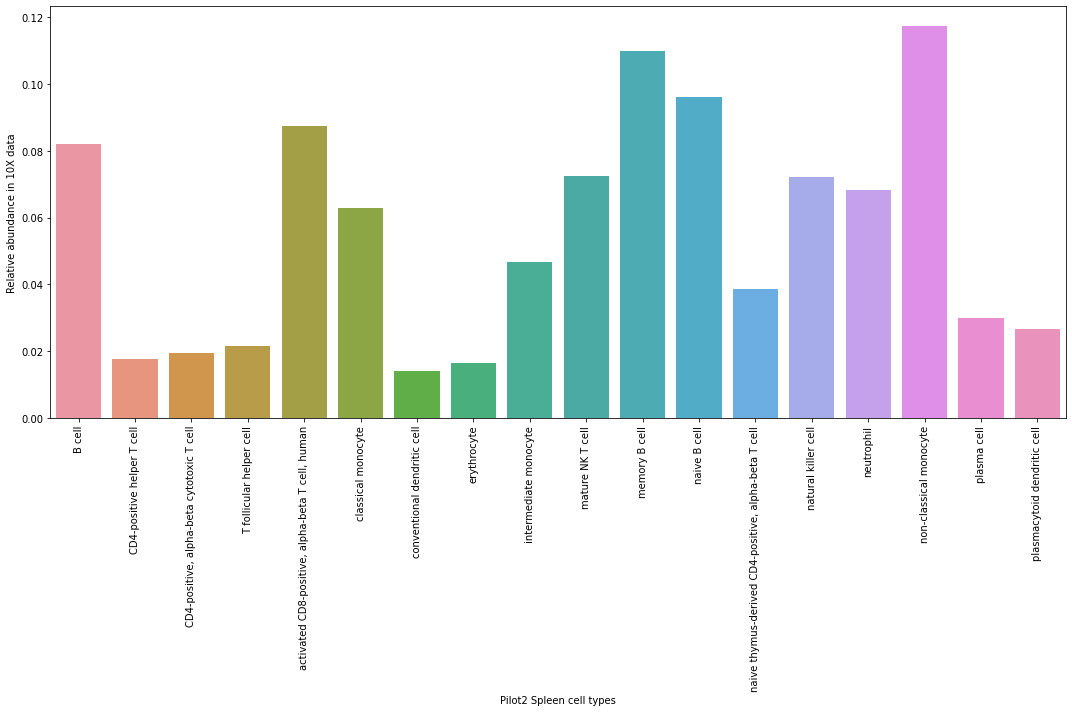

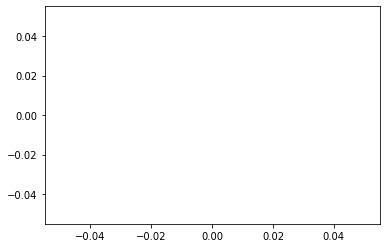

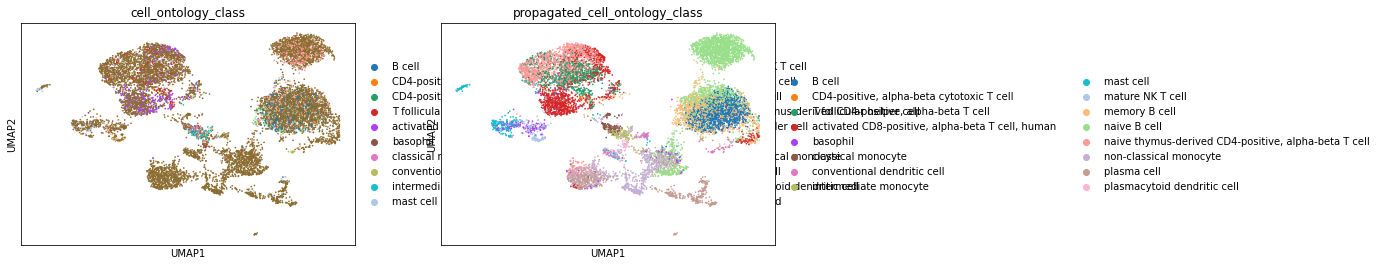

Lung
[2020-06-18 18:29:01,154] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 18:29:01,157] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 18:29:02,070] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 18:29:02,300] INFO - scvi.dataset.dataset | Downsampled from 32519 to 32519 cells


... storing 'propagated_cell_ontology_class' as categorical


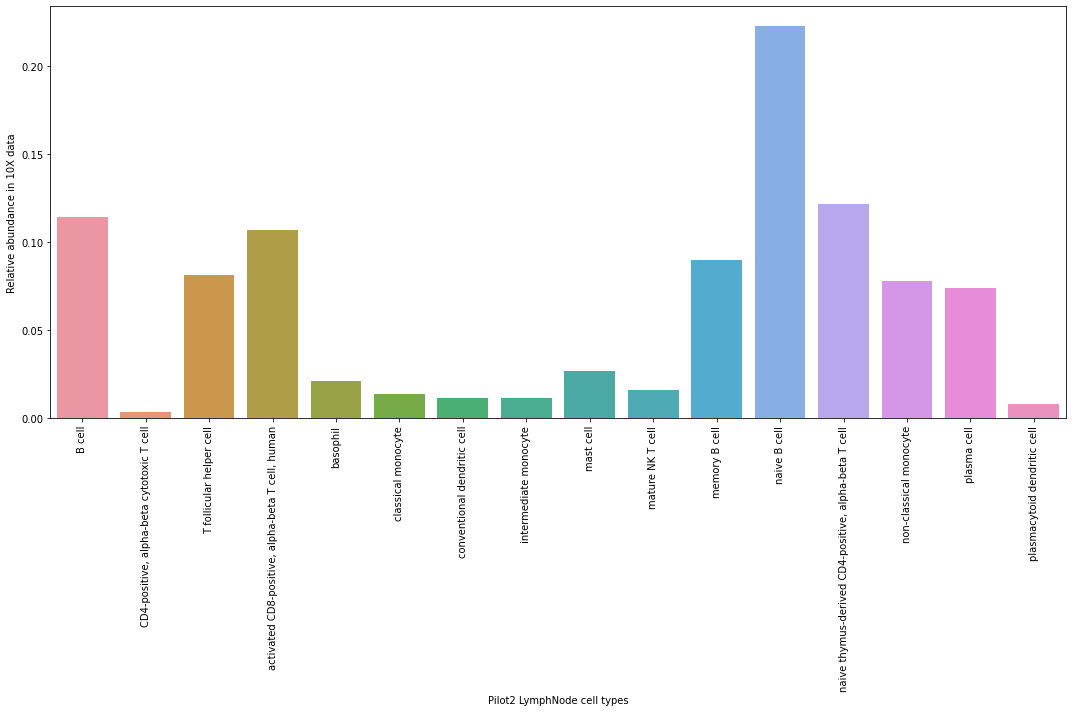

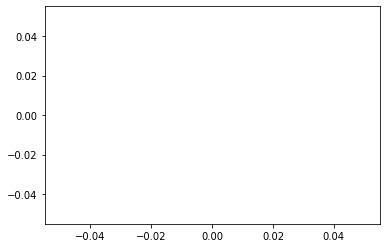

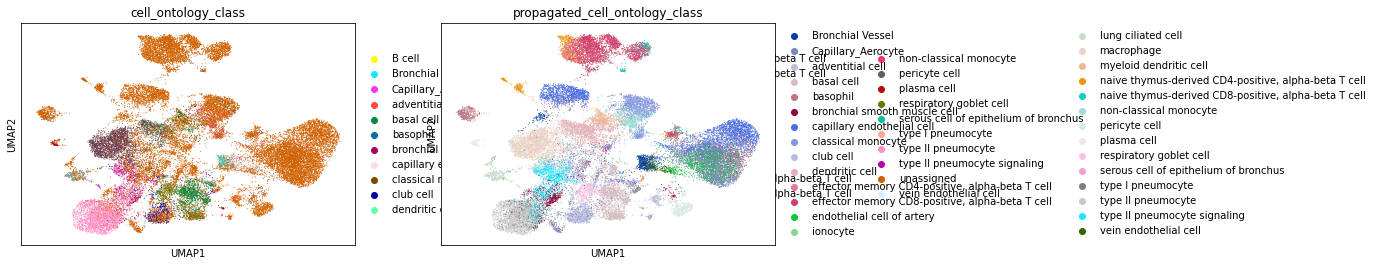

LI
[2020-06-18 18:29:57,986] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 18:29:57,989] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 18:29:58,221] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 18:29:58,267] INFO - scvi.dataset.dataset | Downsampled from 14960 to 14960 cells


... storing 'propagated_cell_ontology_class' as categorical


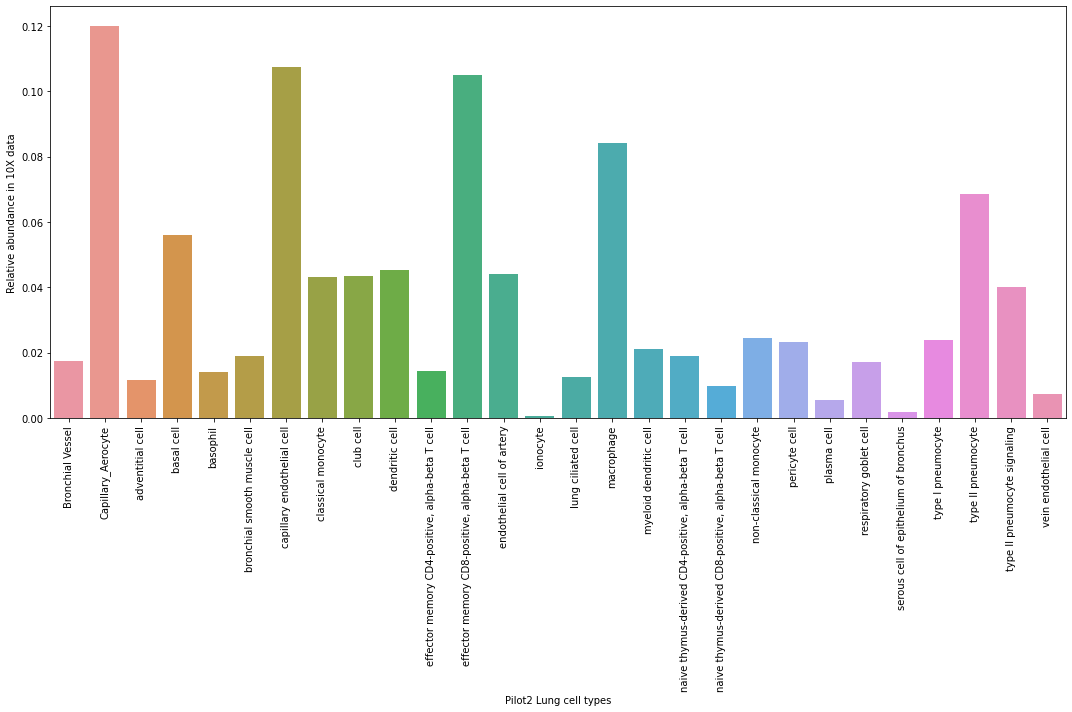

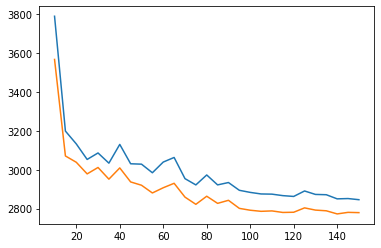

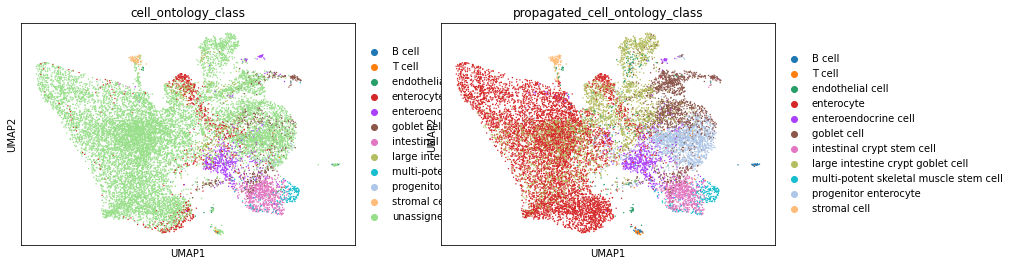

Bladder
[2020-06-18 18:46:32,684] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 18:46:32,686] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 18:46:33,066] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 18:46:33,151] INFO - scvi.dataset.dataset | Downsampled from 13591 to 13591 cells


... storing 'propagated_cell_ontology_class' as categorical


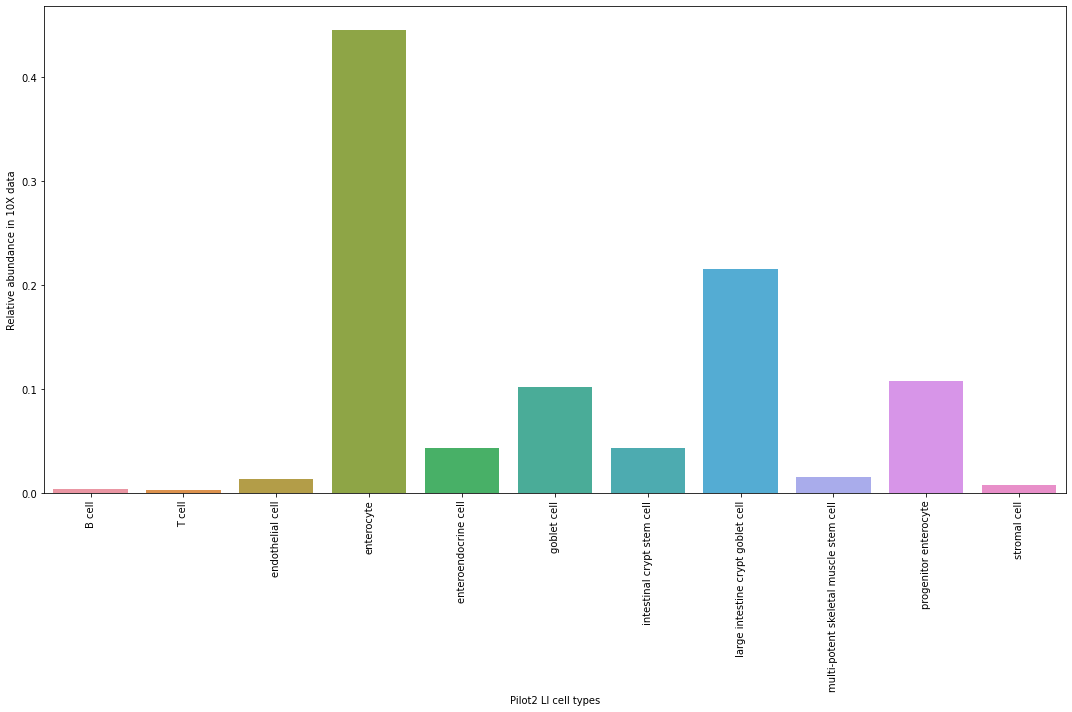

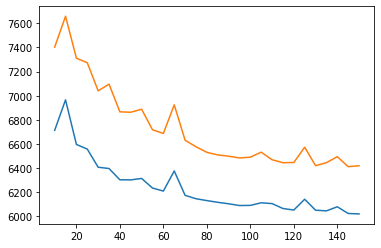

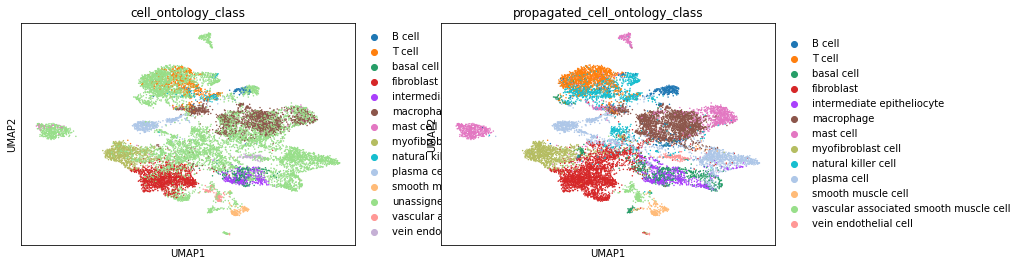

BM
[2020-06-18 19:02:22,249] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 19:02:22,251] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 19:02:22,363] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 19:02:22,390] INFO - scvi.dataset.dataset | Downsampled from 4655 to 4655 cells


... storing 'propagated_cell_ontology_class' as categorical


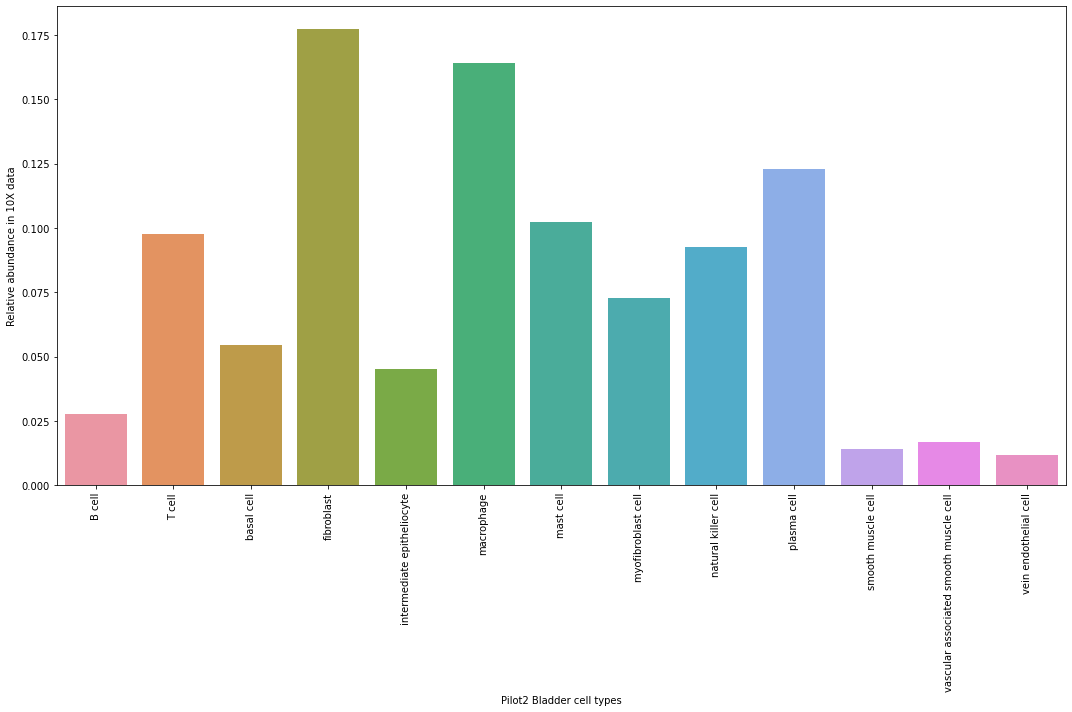

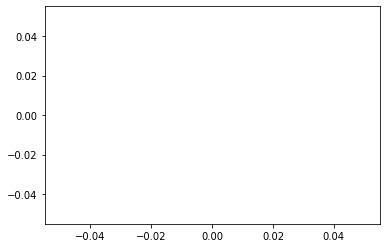

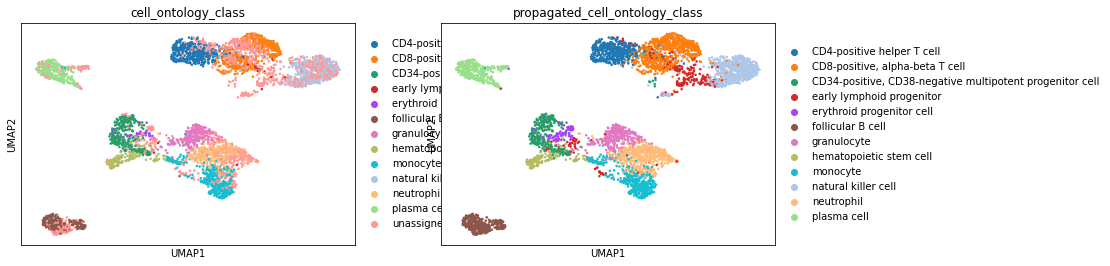

Thymus
[2020-06-18 19:02:42,232] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 19:02:42,234] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 19:02:42,628] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 19:02:42,737] INFO - scvi.dataset.dataset | Downsampled from 15958 to 15958 cells


... storing 'propagated_cell_ontology_class' as categorical


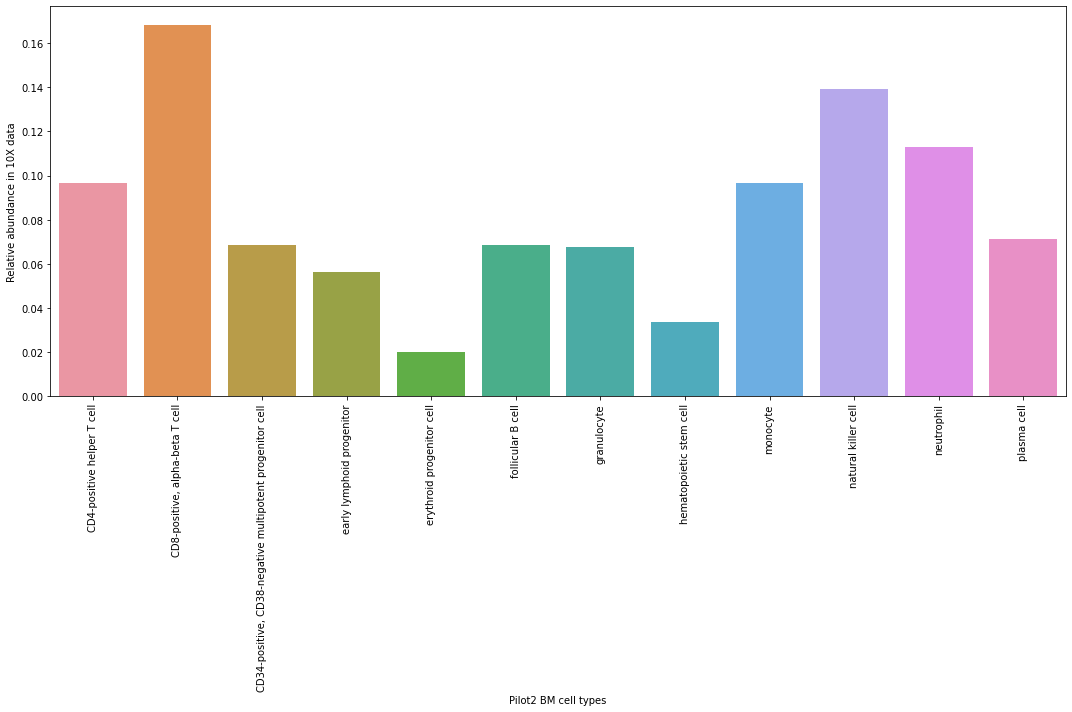

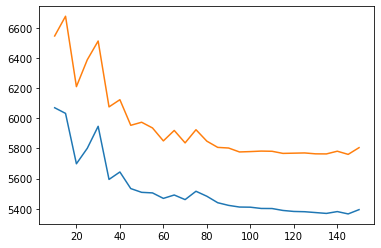

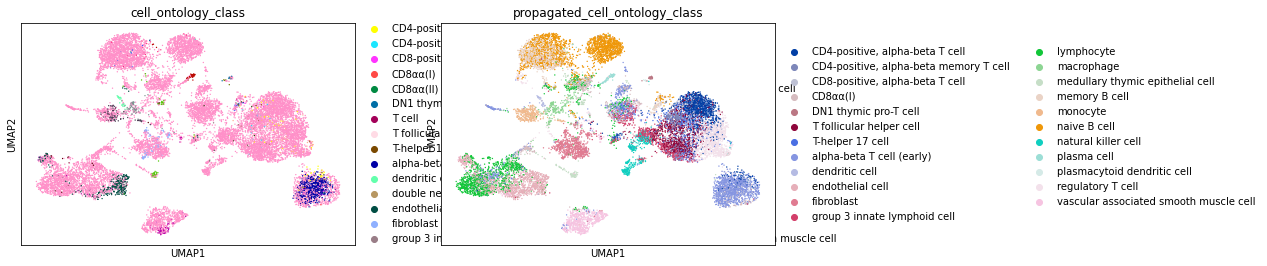

Trachea
[2020-06-18 19:21:09,762] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 19:21:09,764] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 19:21:10,185] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 19:21:10,305] INFO - scvi.dataset.dataset | Downsampled from 21936 to 21936 cells


... storing 'propagated_cell_ontology_class' as categorical


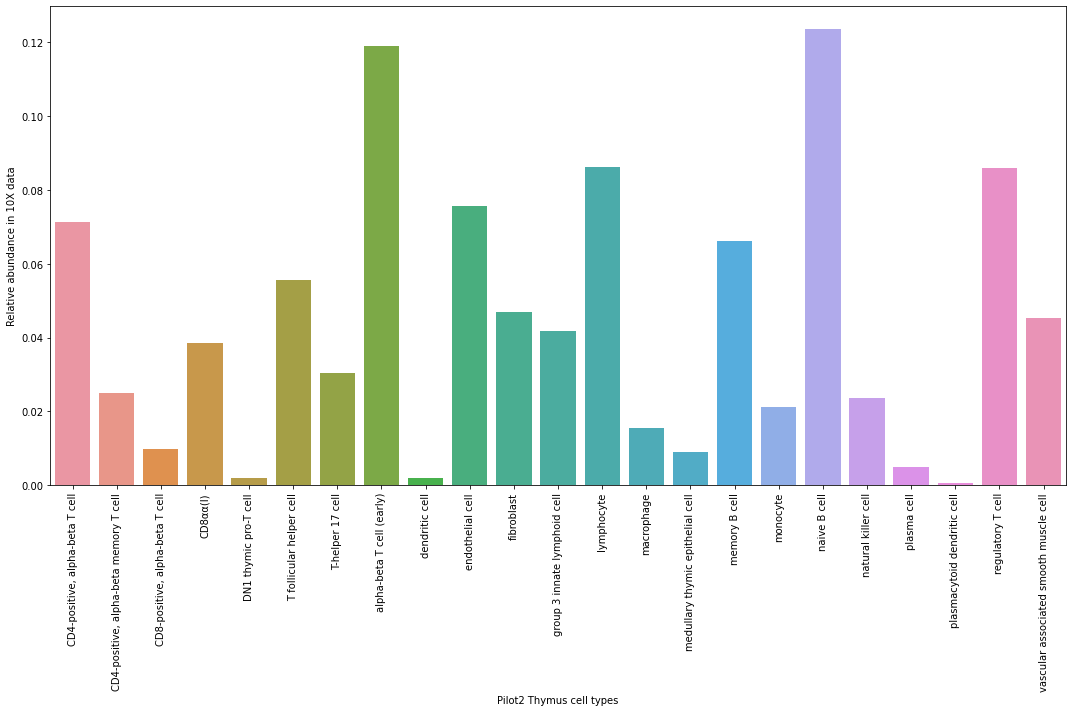

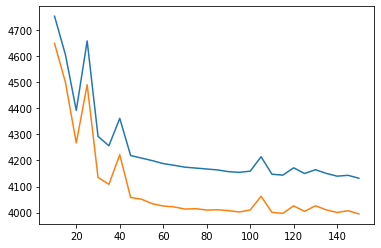

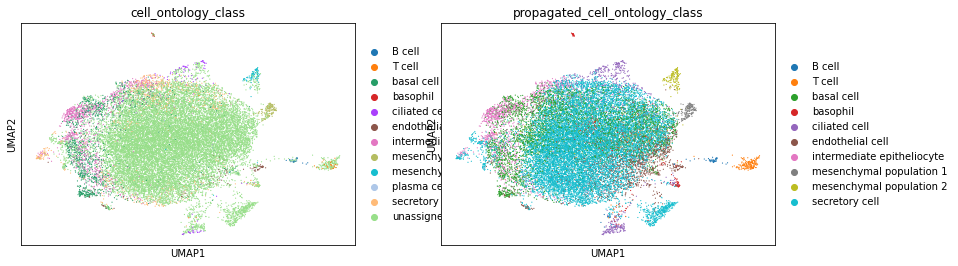

Blood
[2020-06-18 19:45:20,701] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-18 19:45:20,703] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-18 19:45:21,096] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-18 19:45:21,182] INFO - scvi.dataset.dataset | Downsampled from 14930 to 14930 cells


... storing 'propagated_cell_ontology_class' as categorical


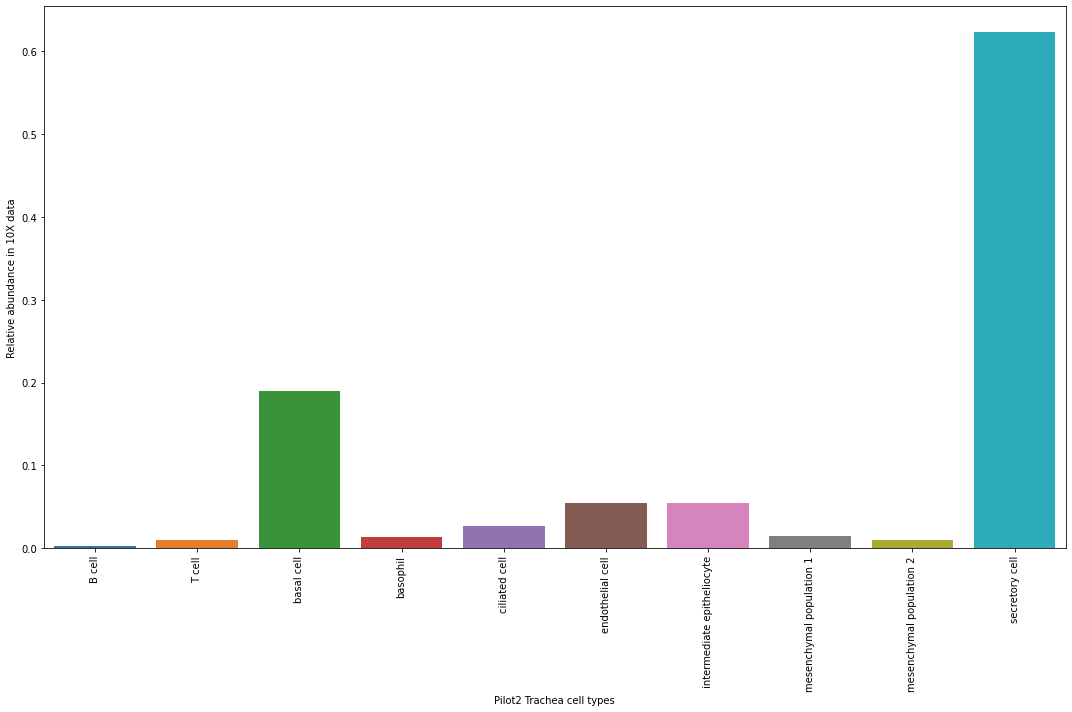

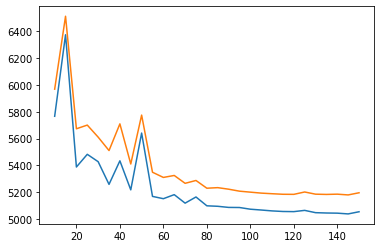

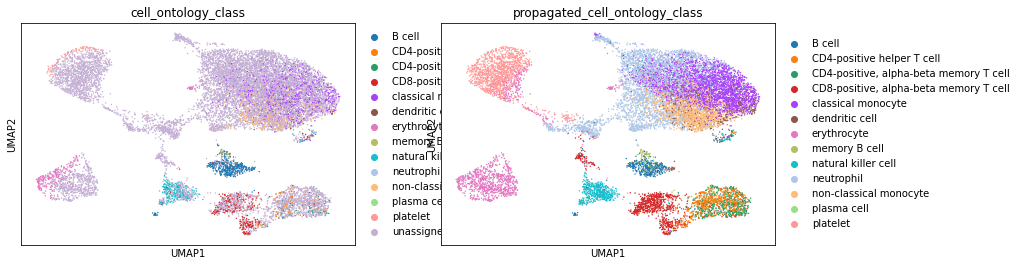

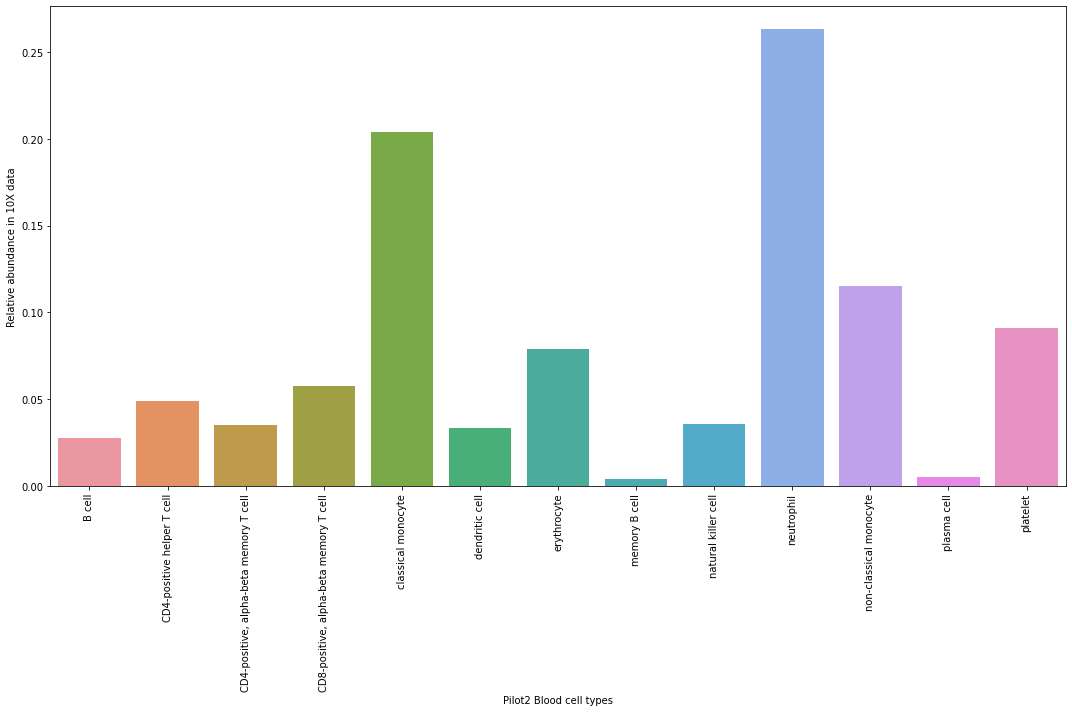

In [13]:
for organ in set(pilot2.obs['tissue']):
    print(organ)
    
    plt.figure()
    pilot2_organ = pilot2[pilot2.obs['tissue']==organ].copy()
    train_data = scVIdata_preprocess(pilot2_organ, 'Tissue Tech', 'cell_ontology_class')
    posterior = get_scvi_posterior(train_data, 
                               model_path+'TSP2.%s.scVI.pkl'%organ, 
                               retrain=retrain)

    full, pred_celltype = scanvi_pred(train_data, 
                                      model_path+'TSP2.%s.scVI.pkl'%organ,
                                      model_path+'TSP2.%s.scANVI.pkl'%organ,
                                      nlabels=30, retrain=retrain)

    pred_celltype = np.asarray([train_data.cell_types[x] for x in pred_celltype])
    [x for x in train_data.cell_types if x not in np.unique(pred_celltype)]

    a,b = np.unique(pred_celltype, return_counts=True)
    pd.DataFrame([a,b,b/np.sum(b)]).T

    pilot2_organ.obs['propagated_cell_ontology_class'] = pred_celltype
    pilot2_organ.obs.to_csv(model_path+'Pilot2.cellontology.'+organ+'.csv')
    
    sc.pp.neighbors(pilot2_organ, n_neighbors=20, n_pcs=30, use_rep="X_scvi")
    sc.tl.umap(pilot2_organ)
    
    sc.pl.umap(pilot2_organ, color=['cell_ontology_class','propagated_cell_ontology_class'])
    
    aux = pilot2_organ.obs.groupby(['propagated_cell_ontology_class'])['sample'].count()
    aux = pd.DataFrame(aux).reset_index()
    aux['sample'] = aux['sample']/aux['sample'].sum()

    f, ax = plt.subplots(figsize=(15,10)) 
    g = sns.barplot(data = aux, y = 'sample',x = 'propagated_cell_ontology_class', ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
    ax.set(xlabel="Pilot2 "+organ+' cell types', ylabel='Relative abundance in 10X data');
    plt.tight_layout()
    plt.savefig("../publication/v0/cell_fractions/Pilot2_"+organ+'.pdf')